# Сравнение на Базов и Подобрен Модел

Този notebook сравнява:
- **Базов модел**: `StockTransformer` (само технически features)
- **Подобрен модел**: `StockTransformerWithNews` (технически features + news embeddings)

## Метрики за сравнение:
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)
- MAPE (Mean Absolute Percentage Error)
- R² (R-squared)
- Directional Accuracy

In [1]:
import sys
from pathlib import Path

project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

import os
os.chdir(project_root)

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from src.data.pipeline import get_datasets
from src.data.pipeline_with_news import get_datasets_with_news
from src.models.transformer_model import StockTransformer
from src.models.transformer_model_with_news import StockTransformerWithNews
from src.evaluation.metrics import calculate_metrics
from src.utils.config import load_config

config = load_config()

print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(f"Tickers: {config.data.tickers}")
print(f"Context length: {config.data.context_length}")
print(f"Prediction horizon: {config.data.prediction_horizon}")
print("=" * 60)

MODEL COMPARISON
Tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
Context length: 60
Prediction horizon: 1


In [3]:
# Load base model datasets (without news)
print("\n📊 Loading BASE model datasets (without news)...")
config.data.use_news = False
train_dataset_base, val_dataset_base, test_dataset_base, feature_columns = get_datasets(
    config=config
)

print(f"✅ Base datasets loaded!")
print(f"  Train: {len(train_dataset_base)} samples")
print(f"  Val: {len(val_dataset_base)} samples")
print(f"  Test: {len(test_dataset_base)} samples")
print(f"  Features: {len(feature_columns)}")


📊 Loading BASE model datasets (without news)...
Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (10068, 25)
✅ Base datasets loaded!
  Train: 6876 samples
  Val: 1426 samples
  Test: 1427 samples
  Features: 34


In [4]:
# Load enhanced model datasets (with news)
print("\n📊 Loading ENHANCED model datasets (with news)...")
config.data.use_news = True
train_dataset_news, val_dataset_news, test_dataset_news, feature_columns_news = get_datasets_with_news(
    config=config,
    use_news_cache=True,
    force_refresh_news=False
)

print(f"✅ Enhanced datasets loaded!")
print(f"  Train: {len(train_dataset_news)} samples")
print(f"  Val: {len(val_dataset_news)} samples")
print(f"  Test: {len(test_dataset_news)} samples")
print(f"  Features: {len(feature_columns_news)}")


📊 Loading ENHANCED model datasets (with news)...
Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (10068, 25)

📰 Extracting news embeddings...
Loading FinBERT encoder...
Loading FinBERT model: ProsusAI/finbert
Device: cpu
✅ FinBERT loaded successfully
📦 Loading cached news embeddings for AAPL from data\processed\news_cache\AAPL_20100105_20200930.pkl
📦 Loading cached news embeddings for AMZN from data\processed\news_cache\AMZN_20100105_20200930.pkl
📦 Loading cached news embeddings for GOOGL from data\processed\news_cache\GOOGL_20100105_20200930.pkl
📦 Loading cached news embeddings for MSFT from data\processed\news_cache\MSFT_20100105_20200930.pkl
✅ News embeddings extracted: (4, 770)
✅ Enhanced datasets loaded!
  Train: 6876 samples
  Val: 1426 samples
  Test: 1427 samples
  Features: 34


In [5]:
# Load base model
print("\n🔧 Loading BASE model...")
from src.utils.config import PROJECT_ROOT

# Try to load base model - check multiple possible locations
base_model_paths = [
    PROJECT_ROOT / "models/checkpoints/best_model_base.pt",  # Explicit base model
    PROJECT_ROOT / "models/checkpoints/best_model.pt",  # Default location
]

base_model_path = None
for path in base_model_paths:
    if path.exists():
        base_model_path = path
        print(f"  Found model at: {path}")
        break

if base_model_path is None:
    print(f"⚠️  Base model not found in any of these locations:")
    for path in base_model_paths:
        print(f"    - {path}")
    print("  Will skip base model evaluation")
    base_model = None

base_model = None
if base_model_path.exists():
    # Use weights_only=False because checkpoint may contain Config object
    checkpoint = torch.load(base_model_path, map_location='cpu', weights_only=False)
    state_dict = checkpoint['model_state_dict']
    
    # Check if this is actually a base model or enhanced model
    model_type = checkpoint.get('model_type', 'unknown')
    
    # Check if state_dict has news-related keys
    has_news = any('news' in key for key in state_dict.keys())
    
    if has_news or model_type == 'StockTransformerWithNews':
        print(f"⚠️  Warning: {base_model_path} contains enhanced model, not base model")
        print("  Attempting to load as base model by filtering out news-related keys...")
        
        # Try to load only base model parts (filter out news keys)
        filtered_state_dict = {k: v for k, v in state_dict.items() if 'news' not in k}
        
        # Also need to adjust output_projection if it was for concat fusion
        if 'output_projection.weight' in state_dict:
            output_shape = state_dict['output_projection.weight'].shape
            # If output_dim is large (concat fusion), we need to create new output_projection
            if 'input_projection.weight' in filtered_state_dict:
                inferred_d_model = filtered_state_dict['input_projection.weight'].shape[0]
                # Create base model with correct d_model
                base_model = StockTransformer(
                    input_dim=len(feature_columns),
                    d_model=inferred_d_model,
                    n_heads=config.model.n_heads,
                    n_layers=config.model.n_layers,
                    d_ff=config.model.d_ff,
                    dropout=config.model.dropout,
                    activation=config.model.activation,
                    prediction_horizon=config.data.prediction_horizon,
                )
                # Remove output_projection from filtered dict and let model use its own
                filtered_state_dict.pop('output_projection.weight', None)
                filtered_state_dict.pop('output_projection.bias', None)
                
                try:
                    base_model.load_state_dict(filtered_state_dict, strict=False)
                    base_model.eval()
                    print(f"✅ Base model loaded (filtered from enhanced model)")
                    print(f"  Validation loss: {checkpoint.get('score', 'N/A'):.6f}")
                    print(f"  Note: Using base model architecture, news weights ignored")
                except Exception as e:
                    print(f"❌ Error loading filtered base model: {e}")
                    base_model = None
            else:
                base_model = None
        else:
            base_model = None
    else:
        # Try to infer model parameters from checkpoint
        # Get d_model from output_projection shape (for base model, output_dim = d_model)
        if 'output_projection.weight' in state_dict:
            output_shape = state_dict['output_projection.weight'].shape
            # For base model, output_projection is [prediction_horizon, d_model]
            # But if it's [1, 256], d_model might be 256 or the output was concatenated
            # Check input_projection instead
            if 'input_projection.weight' in state_dict:
                inferred_d_model = state_dict['input_projection.weight'].shape[0]
            else:
                inferred_d_model = config.model.d_model
        else:
            inferred_d_model = config.model.d_model
        
        base_model = StockTransformer(
            input_dim=len(feature_columns),
            d_model=inferred_d_model,
            n_heads=config.model.n_heads,
            n_layers=config.model.n_layers,
            d_ff=config.model.d_ff,
            dropout=config.model.dropout,
            activation=config.model.activation,
            prediction_horizon=config.data.prediction_horizon,
        )
        
        try:
            # Use strict=False to ignore news-related keys if any
            base_model.load_state_dict(state_dict, strict=False)
            base_model.eval()
            print(f"✅ Base model loaded from {base_model_path}")
            print(f"  Validation loss: {checkpoint.get('score', 'N/A'):.6f}")
            print(f"  Inferred d_model: {inferred_d_model}")
        except Exception as e:
            print(f"❌ Error loading base model: {e}")
            print("  Will skip base model evaluation")
            base_model = None
else:
    if base_model_path is not None:
        print(f"⚠️  Base model not found at {base_model_path}")
    print("  Will skip base model evaluation")
    base_model = None


🔧 Loading BASE model...
  Found model at: C:\Users\vyoto\OneDrive\Desktop\CODE STUFF\Stock price prediction\models\checkpoints\best_model_base.pt
✅ Base model loaded from C:\Users\vyoto\OneDrive\Desktop\CODE STUFF\Stock price prediction\models\checkpoints\best_model_base.pt
  Validation loss: 0.017291
  Inferred d_model: 128


In [6]:
# Load enhanced model
print("\n🔧 Loading ENHANCED model...")
from src.utils.config import PROJECT_ROOT
enhanced_model_path = PROJECT_ROOT / "models/checkpoints/best_model_with_news.pt"

enhanced_model = None
if enhanced_model_path.exists():
    # Use weights_only=False because checkpoint may contain Config object
    checkpoint = torch.load(enhanced_model_path, map_location='cpu', weights_only=False)
    state_dict = checkpoint['model_state_dict']
    
    # Try to infer model parameters from checkpoint
    # Get d_model from input_projection
    if 'input_projection.weight' in state_dict:
        inferred_d_model = state_dict['input_projection.weight'].shape[0]
    elif 'encoder.layers.0.self_attention.q_proj.weight' in state_dict:
        # Infer from attention layer
        inferred_d_model = state_dict['encoder.layers.0.self_attention.q_proj.weight'].shape[0]
    else:
        inferred_d_model = config.model.d_model
    
    # Check output_projection to determine fusion method
    if 'output_projection.weight' in state_dict:
        output_shape = state_dict['output_projection.weight'].shape
        # If output_dim > d_model, likely using concat fusion
        # For concat: output_dim = d_model + news_proj_dim (usually d_model)
        # So output_dim should be around 2 * d_model for concat
        if output_shape[1] > inferred_d_model * 1.5:
            inferred_fusion = "concat"
        else:
            inferred_fusion = "add"
    else:
        inferred_fusion = "concat"
    
    # Use feature_columns_news if available, otherwise use feature_columns
    # (they should be the same for technical features, news embeddings are separate)
    input_dim = len(feature_columns_news) if 'feature_columns_news' in globals() else len(feature_columns)
    
    enhanced_model = StockTransformerWithNews(
        input_dim=input_dim,
        news_embedding_dim=768,
        d_model=inferred_d_model,
        n_heads=config.model.n_heads,
        n_layers=config.model.n_layers,
        d_ff=config.model.d_ff,
        dropout=config.model.dropout,
        activation=config.model.activation,
        prediction_horizon=config.data.prediction_horizon,
        news_fusion_method=inferred_fusion,
    )
    
    try:
        enhanced_model.load_state_dict(state_dict, strict=False)
        enhanced_model.eval()
        print(f"✅ Enhanced model loaded from {enhanced_model_path}")
        print(f"  Validation loss: {checkpoint.get('score', 'N/A'):.6f}")
        print(f"  Inferred d_model: {inferred_d_model}")
        print(f"  Inferred fusion method: {inferred_fusion}")
    except Exception as e:
        print(f"❌ Error loading enhanced model: {e}")
        print("  Will skip enhanced model evaluation")
        enhanced_model = None
else:
    print(f"⚠️  Enhanced model not found at {enhanced_model_path}")
    print("  Will skip enhanced model evaluation")
    enhanced_model = None


🔧 Loading ENHANCED model...
✅ Enhanced model loaded from C:\Users\vyoto\OneDrive\Desktop\CODE STUFF\Stock price prediction\models\checkpoints\best_model_with_news.pt
  Validation loss: 0.017069
  Inferred d_model: 128
  Inferred fusion method: concat


In [7]:
# Evaluate base model on test set
print("\n" + "=" * 60)
print("EVALUATING BASE MODEL")
print("=" * 60)

base_predictions = []
base_targets = []

if base_model is not None:
    test_loader_base = DataLoader(
        test_dataset_base,
        batch_size=config.training.batch_size,
        shuffle=False,
        num_workers=0,
    )
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    base_model.to(device)
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader_base:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            pred = base_model(batch_x)
            
            base_predictions.append(pred.cpu().numpy())
            base_targets.append(batch_y.cpu().numpy())
    
    base_predictions = np.concatenate(base_predictions, axis=0)
    base_targets = np.concatenate(base_targets, axis=0)
    
    # Flatten if needed
    if base_predictions.ndim > 1:
        base_predictions = base_predictions.flatten()
    if base_targets.ndim > 1:
        base_targets = base_targets.flatten()
    
    # Calculate metrics
    base_metrics = calculate_metrics(base_targets, base_predictions)
    
    print("\n📊 Base Model Metrics:")
    for metric_name, metric_value in base_metrics.items():
        print(f"  {metric_name}: {metric_value:.6f}")
else:
    base_predictions = None
    base_targets = None
    base_metrics = None
    print("⚠️  Base model not available")


EVALUATING BASE MODEL



📊 Base Model Metrics:
  mae: 0.069719
  rmse: 0.086657
  mape: 11.476754
  r2: -0.301045
  directional_accuracy: 0.469144


In [8]:
# Evaluate enhanced model on test set
print("\n" + "=" * 60)
print("EVALUATING ENHANCED MODEL")
print("=" * 60)

enhanced_predictions = []
enhanced_targets = []

if enhanced_model is not None:
    test_loader_news = DataLoader(
        test_dataset_news,
        batch_size=config.training.batch_size,
        shuffle=False,
        num_workers=0,
    )
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    enhanced_model.to(device)
    
    with torch.no_grad():
        for batch in test_loader_news:
            if len(batch) == 3:
                batch_x, news_emb, batch_y = batch
                news_emb = news_emb.to(device) if news_emb is not None else None
            else:
                batch_x, batch_y = batch
                news_emb = None
            
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            if news_emb is not None:
                pred = enhanced_model(batch_x, news_embeddings=news_emb)
            else:
                pred = enhanced_model(batch_x)
            
            enhanced_predictions.append(pred.cpu().numpy())
            enhanced_targets.append(batch_y.cpu().numpy())
    
    enhanced_predictions = np.concatenate(enhanced_predictions, axis=0)
    enhanced_targets = np.concatenate(enhanced_targets, axis=0)
    
    # Flatten if needed
    if enhanced_predictions.ndim > 1:
        enhanced_predictions = enhanced_predictions.flatten()
    if enhanced_targets.ndim > 1:
        enhanced_targets = enhanced_targets.flatten()
    
    # Calculate metrics
    enhanced_metrics = calculate_metrics(enhanced_targets, enhanced_predictions)
    
    print("\n📊 Enhanced Model Metrics:")
    for metric_name, metric_value in enhanced_metrics.items():
        print(f"  {metric_name}: {metric_value:.6f}")
else:
    enhanced_predictions = None
    enhanced_targets = None
    enhanced_metrics = None
    print("⚠️  Enhanced model not available")


EVALUATING ENHANCED MODEL

📊 Enhanced Model Metrics:
  mae: 0.073962
  rmse: 0.088708
  mape: 12.513152
  r2: 0.026553
  directional_accuracy: 0.474755


In [9]:
# Compare metrics
print("\n" + "=" * 60)
print("COMPARISON SUMMARY")
print("=" * 60)

if base_metrics is not None and enhanced_metrics is not None:
    comparison_df = pd.DataFrame({
        'Base Model': base_metrics,
        'Enhanced Model': enhanced_metrics,
    })
    
    # Calculate improvement
    comparison_df['Improvement'] = comparison_df['Base Model'] - comparison_df['Enhanced Model']
    comparison_df['Improvement %'] = (
        (comparison_df['Base Model'] - comparison_df['Enhanced Model']) / 
        comparison_df['Base Model'].abs() * 100
    )
    
    # For metrics where lower is better (MAE, RMSE, MAPE), positive improvement is good
    # For metrics where higher is better (R², Directional Accuracy), negative improvement is good
    # So we need to adjust the sign
    for metric in ['R²', 'directional_accuracy']:
        if metric in comparison_df.index:
            comparison_df.loc[metric, 'Improvement'] = -comparison_df.loc[metric, 'Improvement']
            comparison_df.loc[metric, 'Improvement %'] = -comparison_df.loc[metric, 'Improvement %']
    
    print("\n📊 Metrics Comparison:")
    print(comparison_df.to_string())
    
    print("\n✅ Interpretation:")
    print("  - For MAE, RMSE, MAPE: Negative 'Improvement' = Better (lower error)")
    print("  - For R², Directional Accuracy: Positive 'Improvement' = Better (higher score)")
    
elif base_metrics is not None:
    print("\n📊 Only Base Model available:")
    print(pd.Series(base_metrics).to_string())
elif enhanced_metrics is not None:
    print("\n📊 Only Enhanced Model available:")
    print(pd.Series(enhanced_metrics).to_string())
else:
    print("\n⚠️  No models available for comparison")


COMPARISON SUMMARY

📊 Metrics Comparison:
                      Base Model  Enhanced Model  Improvement  Improvement %
mae                     0.069719        0.073962    -0.004243      -6.085959
rmse                    0.086657        0.088708    -0.002050      -2.365778
mape                   11.476754       12.513152    -1.036397      -9.030405
r2                     -0.301045        0.026553    -0.327597    -108.820141
directional_accuracy    0.469144        0.474755     0.005610       1.195815

✅ Interpretation:
  - For MAE, RMSE, MAPE: Negative 'Improvement' = Better (lower error)
  - For R², Directional Accuracy: Positive 'Improvement' = Better (higher score)



✅ Comparison plots saved to results/plots/model_comparison.png


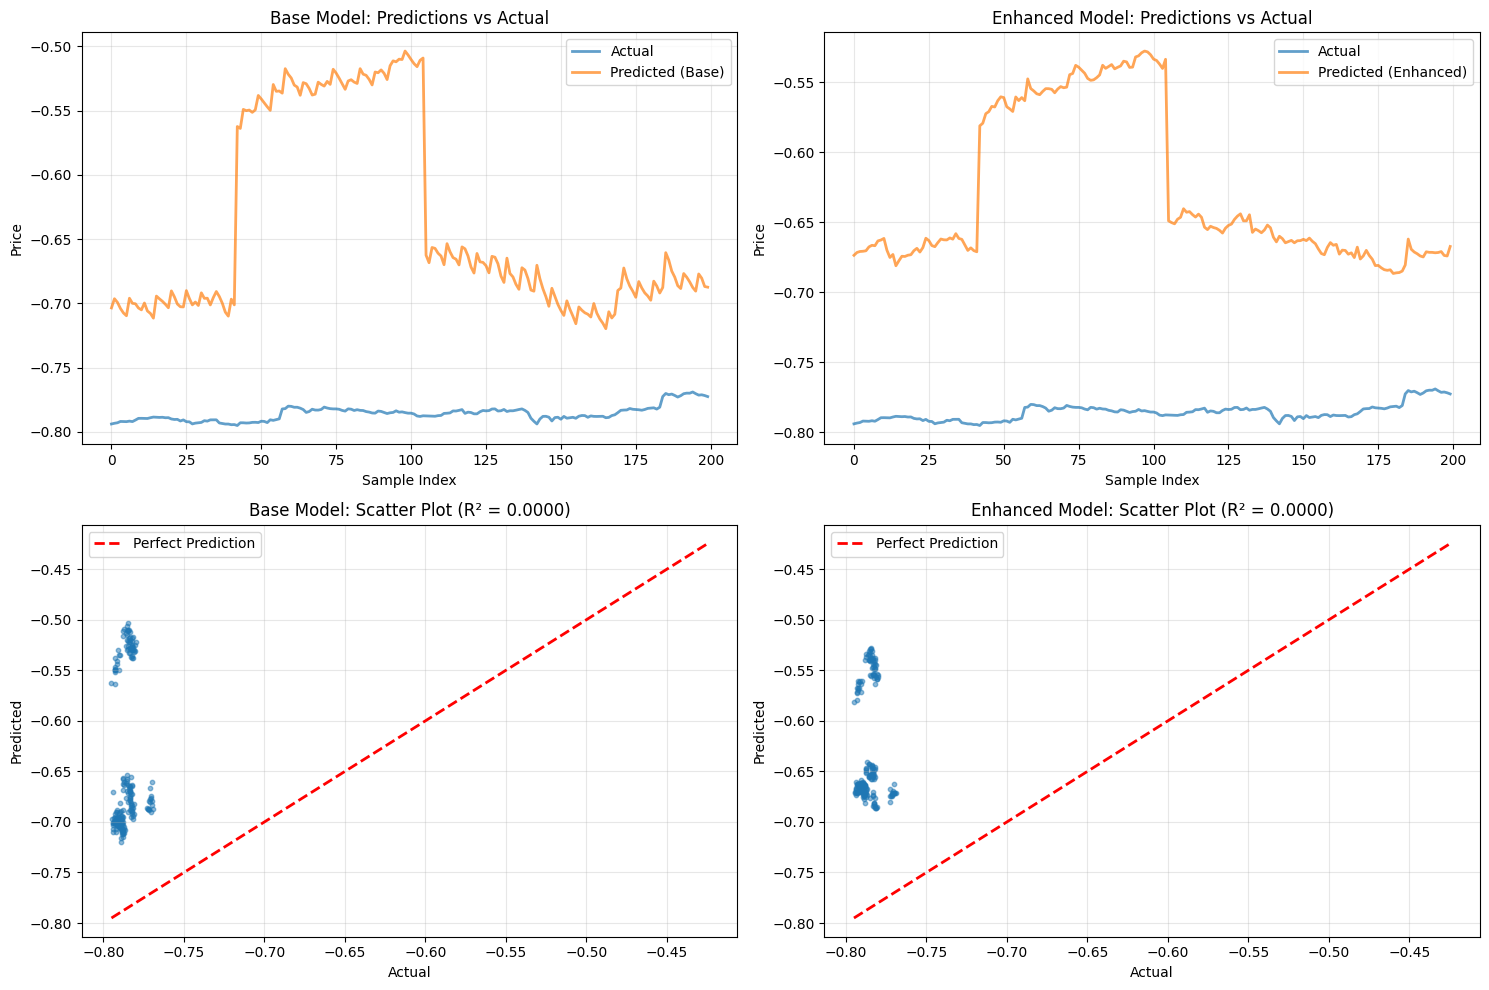

In [10]:
# Visualize predictions
if base_predictions is not None and enhanced_predictions is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Sample subset for visualization (first 200 points)
    n_samples = min(200, len(base_predictions))
    indices = np.arange(n_samples)
    
    # Plot 1: Predictions vs Actual (Base Model)
    axes[0, 0].plot(indices, base_targets[:n_samples], label='Actual', alpha=0.7, linewidth=2)
    axes[0, 0].plot(indices, base_predictions[:n_samples], label='Predicted (Base)', alpha=0.7, linewidth=2)
    axes[0, 0].set_title('Base Model: Predictions vs Actual')
    axes[0, 0].set_xlabel('Sample Index')
    axes[0, 0].set_ylabel('Price')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Predictions vs Actual (Enhanced Model)
    axes[0, 1].plot(indices, enhanced_targets[:n_samples], label='Actual', alpha=0.7, linewidth=2)
    axes[0, 1].plot(indices, enhanced_predictions[:n_samples], label='Predicted (Enhanced)', alpha=0.7, linewidth=2)
    axes[0, 1].set_title('Enhanced Model: Predictions vs Actual')
    axes[0, 1].set_xlabel('Sample Index')
    axes[0, 1].set_ylabel('Price')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Scatter plot (Base Model)
    axes[1, 0].scatter(base_targets[:n_samples], base_predictions[:n_samples], alpha=0.5, s=10)
    axes[1, 0].plot([base_targets.min(), base_targets.max()], 
                    [base_targets.min(), base_targets.max()], 
                    'r--', linewidth=2, label='Perfect Prediction')
    axes[1, 0].set_title(f'Base Model: Scatter Plot (R² = {base_metrics.get("R²", 0):.4f})')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Scatter plot (Enhanced Model)
    axes[1, 1].scatter(enhanced_targets[:n_samples], enhanced_predictions[:n_samples], alpha=0.5, s=10)
    axes[1, 1].plot([enhanced_targets.min(), enhanced_targets.max()], 
                     [enhanced_targets.min(), enhanced_targets.max()], 
                     'r--', linewidth=2, label='Perfect Prediction')
    axes[1, 1].set_title(f'Enhanced Model: Scatter Plot (R² = {enhanced_metrics.get("R²", 0):.4f})')
    axes[1, 1].set_xlabel('Actual')
    axes[1, 1].set_ylabel('Predicted')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results/plots/model_comparison.png', dpi=150, bbox_inches='tight')
    print("\n✅ Comparison plots saved to results/plots/model_comparison.png")
    plt.show()
    
elif base_predictions is not None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    n_samples = min(200, len(base_predictions))
    indices = np.arange(n_samples)
    
    axes[0].plot(indices, base_targets[:n_samples], label='Actual', alpha=0.7, linewidth=2)
    axes[0].plot(indices, base_predictions[:n_samples], label='Predicted', alpha=0.7, linewidth=2)
    axes[0].set_title('Base Model: Predictions vs Actual')
    axes[0].set_xlabel('Sample Index')
    axes[0].set_ylabel('Price')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].scatter(base_targets[:n_samples], base_predictions[:n_samples], alpha=0.5, s=10)
    axes[1].plot([base_targets.min(), base_targets.max()], 
                 [base_targets.min(), base_targets.max()], 
                 'r--', linewidth=2, label='Perfect Prediction')
    axes[1].set_title(f'Base Model: Scatter Plot (R² = {base_metrics.get("R²", 0):.4f})')
    axes[1].set_xlabel('Actual')
    axes[1].set_ylabel('Predicted')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
elif enhanced_predictions is not None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    n_samples = min(200, len(enhanced_predictions))
    indices = np.arange(n_samples)
    
    axes[0].plot(indices, enhanced_targets[:n_samples], label='Actual', alpha=0.7, linewidth=2)
    axes[0].plot(indices, enhanced_predictions[:n_samples], label='Predicted', alpha=0.7, linewidth=2)
    axes[0].set_title('Enhanced Model: Predictions vs Actual')
    axes[0].set_xlabel('Sample Index')
    axes[0].set_ylabel('Price')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].scatter(enhanced_targets[:n_samples], enhanced_predictions[:n_samples], alpha=0.5, s=10)
    axes[1].plot([enhanced_targets.min(), enhanced_targets.max()], 
                 [enhanced_targets.min(), enhanced_targets.max()], 
                 'r--', linewidth=2, label='Perfect Prediction')
    axes[1].set_title(f'Enhanced Model: Scatter Plot (R² = {enhanced_metrics.get("R²", 0):.4f})')
    axes[1].set_xlabel('Actual')
    axes[1].set_ylabel('Predicted')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No predictions available for visualization")

## Заключение

Сравнени са двата модела на test set. Провери:
- Кой модел има по-добри метрики?
- Дали новините подобряват прогнозите?
- Кой модел е по-добър за различни метрики?

**Следващи стъпки:**
- Тествай на различни тикъри
- Направи backtesting с двата модела
- Анализирай кога новините помагат най-много